# (Tut 1) Deep Learning Deep Inelastic Scattering at EIC

**Credits:**

Heavily based on:  

- *Reconstructing the Kinematics of Deep Inelastic Scattering with Deep Learning* by Miguel Arratia, Daniel Britzger, Owen Long, Benjamin Nachman arXiv:2110.05505 --- [[code](https://github.com/owen234/DIS-reco-paper), [dataset](https://drive.google.com/file/d/1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7/view)]

- *Deeply Learning Deep Inelastic Scattering Kinematics*, by Markus Diefenthaler, Abdullah Farhat, Andrii Verbytskyi, Yuesheng Xu,arXiv:2108.11638




## Training for H1 rapgap MC with reconstructed observables as input.
### This uses a single DNN with all inputs (electron, HFS, photons)
Adjust Huber delta to 0.01.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Make sure GPU runtime is enabled.
# Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU
# You will likely only have a T4, unless you have colab pro.
!nvidia-smi

Tue May 27 04:39:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
# We need uproot to unpack the ROOT file.
#!pip uninstall -y uproot3
!pip install uproot

Found existing installation: uproot3 3.14.4
Uninstalling uproot3-3.14.4:
  Successfully uninstalled uproot3-3.14.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.7/375.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.1/886.1 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 50.1 MB/s eta 0:00:00


In [21]:
%pip install awkward-pandas

  Using cached awkward_pandas-2023.8.0-py3-none-any.whl.metadata (2.1 kB)
Using cached awkward_pandas-2023.8.0-py3-none-any.whl (11 kB)


In [16]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot

import matplotlib as mpl

from datetime import datetime
import subprocess

import seaborn as sns


In [49]:
#has_gpu = False

has_gpu = True

training_name = 'training_h1_reg_hugs25_v1'

#training_extname = "/content/drive/My Drive/projects/DIS-reco/DIS-reco-paper/"+training_name

saving_dir = "/content/drive/My Drive/TMP/"

training_extname = saving_dir+training_name


#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
max_events = 10e6
#max_events =  3000000
#max_events = 15000000


learning_rate_setval_reg = 1e-5
batch_size_setval = 1024
max_epochs = 25
dropout_setval = 0.0
amsgrad_setval = False
delta_setval = 0.01

# Path to the ROOT file in your google drive. Make sure your drive is mounted above.
#input_file = '/content/drive/My Drive/projects/DIS-reco/data/all-h1-rapgap.root'

#input_url = 'https://drive.google.com/file/d/1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7/view'

input_id = '1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7'
input_url = 'https://drive.google.com/uc?id='+input_id


outprintfile = training_extname+"-setup.txt"

parfile = open(outprintfile,'w')

parfile.write('%s\n' % datetime.now())
parfile.write('training_name : %s\n' % training_extname )
parfile.write('input_file : %s\n' % input_id ) #input_file
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval_reg )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )
parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
parfile.write('delta_setval : %g\n' % delta_setval )

parfile.close()

command_string = ("cat '%s'")% outprintfile

print( subprocess.getoutput(command_string) )
print('\n\n')






2025-05-27 05:28:30.764762
training_name : /content/drive/My Drive/TMP/training_h1_reg_hugs25_v1
input_file : 1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7
max_events : 10000000
learning_rate_setval_reg : 1e-05
batch_size_setval : 1024
max_epochs : 50
dropout_setval : 0
amsgrad_setval : 0
delta_setval : 0.01





In [10]:
%pip install -q gdown

In [12]:
!gdown --id 1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7 --output myfile.root

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7
From (redirected): https://drive.google.com/uc?id=1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7&confirm=t&uuid=0faca380-f948-40d0-abaf-6b1615044e84
To: /content/myfile.root
100% 6.51G/6.51G [01:01<00:00, 106MB/s]


In [14]:
!head -c 20 myfile.root


root 5A   d   � $N

In [22]:
%%time

#ur_file = uproot3.open(input_file)
ur_file = uproot.open("myfile.root")

print("ur_file.keys(): ", ur_file.keys())

ur_tree = ur_file['Rapgap/minitree']
print(ur_tree)
ur_tree.show()

#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)
pandas_df = ur_tree.arrays(
    [
        'has_isr', 'has_fsr',
        'tower_sum_40', 'n_towers_40',
        'eta_pho_closest_to_ebeam', 'e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
        'obs_x', 'obs_y', 'obs_Q2',
        'from_tlv_gen_Q2', 'from_tlv_gen_x', 'from_tlv_gen_y',
        'obs_e_e', 'obs_e_pz', 'obs_e_pt', 'obs_e_phi',
        'obs_hfs_e', 'obs_hfs_pz', 'obs_hfs_pt', 'obs_hfs_phi',
        'obs_dphi',
        'Empz', 'obs_e_trk_e',
        'beam_e_e'
    ],
    entry_stop=max_events,
    library="pd"
)


print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )


ur_file.keys():  ['Rapgap;1', 'Rapgap/minitree;1', 'Rapgap/DISEvent;1', 'Rapgap/DISEvent/13_1_before_cuts;1', 'Rapgap/DISEvent/13_1_before_cuts_lxy;1', 'Rapgap/DISEvent/13_2_detector_cuts;1', 'Rapgap/DISEvent/13_2_detector_cuts_lxy;1']
<TTree 'minitree' (42 branches) at 0x7a1f7d93b510>
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
wgt                  | float                    | AsDtype('>f4')
Empz                 | float                    | AsDtype('>f4')
from_tlv_gen_Q2      | float                    | AsDtype('>f4')
from_tlv_gen_x       | float                    | AsDtype('>f4')
from_tlv_gen_y       | float                    | AsDtype('>f4')
beam_e_e             | float                    | AsDtype('>f4')
beam_p_e             | float                    | AsDtype('>f4')
has_isr              | int8_t                   | AsDtype('int8')
has_fsr              | int8_t 

In [23]:
print(len(pandas_df))
pandas_df.head()

10000000


,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x,obs_y,obs_Q2,...,obs_e_pt,obs_e_phi,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_dphi,Empz,obs_e_trk_e,beam_e_e
0,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
1,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
2,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
3,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
4,0,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6


In [24]:
pandas_df.tail()

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x,obs_y,obs_Q2,...,obs_e_pt,obs_e_phi,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_dphi,Empz,obs_e_trk_e,beam_e_e
9999995,1,0,0.000000,0,0.000000,0.000000,0.000000,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.6
9999996,0,1,47.094521,2,-0.124716,8.941693,2.411923,[0.058499809354543686 0.05831887200474739 0.05...,[0.4024747610092163 0.4050461947917938 0.40504...,[2391.388916015625 2399.22412109375 2381.09741...,...,37.800995,2.692896,119.429268,97.070717,37.856754,-0.424569,3.117465,55.341942,39.459339,27.6
9999997,0,0,17.333700,1,-0.806077,0.196039,0.073661,[0.004271071404218674 0.002905079396441579 0.0...,[0.43371501564979553 0.4118492603302002 0.4118...,[188.14749145507812 121.5215835571289 195.4123...,...,10.322068,-2.546395,49.432240,26.698160,10.748409,0.720433,3.016356,53.993011,16.515560,27.6
9999998,1,0,0.000000,0,0.000000,0.000000,0.000000,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.6
9999999,0,1,0.000000,0,0.000000,0.000000,0.000000,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.6


In [25]:
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

<ipython-input-25-4103e232d686>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.          0.          0.         ... -2.62005591  0.
  0.        ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
<ipython-input-25-4103e232d686>:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )


In [26]:
pandas_df.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )

In [27]:
pandas_df.head()

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x,obs_y,obs_Q2,...,rot_Empz1,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal
0,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,-2.582836,-4.780699,3.588407,NaN,-1.0,False,NaN,1.0
1,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,-4.570547,-0.797988,5.435722,NaN,-1.0,False,NaN,1.0
2,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,-4.374308,-2.930975,4.217414,NaN,-1.0,False,NaN,1.0
3,1,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,-5.914076,-0.427778,2.654275,NaN,-1.0,False,NaN,1.0
4,0,0,0.0,0,0.0,0.0,0.0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],...,0.0,0.0,-4.279663,-0.961149,6.287672,NaN,-1.0,True,NaN,1.0


In [28]:
nan_columns = pandas_df.columns[pandas_df.isna().any()].tolist()
print(nan_columns)

['e_ecal_over_trk_ratio', 'obs_ptbal']


In [29]:
pandas_df.columns

Index(['has_isr', 'has_fsr', 'tower_sum_40', 'n_towers_40',
       'eta_pho_closest_to_ebeam', 'e_pho_closest_to_ebeam',
       'phi_pho_closest_to_ebeam', 'obs_x', 'obs_y', 'obs_Q2',
       'from_tlv_gen_Q2', 'from_tlv_gen_x', 'from_tlv_gen_y', 'obs_e_e',
       'obs_e_pz', 'obs_e_pt', 'obs_e_phi', 'obs_hfs_e', 'obs_hfs_pz',
       'obs_hfs_pt', 'obs_hfs_phi', 'obs_dphi', 'Empz', 'obs_e_trk_e',
       'beam_e_e', 'obs_hfs_Empz', 'obs_e_Empz', 'obs_event_Empz', 'rot_pt1',
       'rot_pt2', 'rot_Empz1', 'rot_Empz2', 'gen_log_x', 'gen_log_y',
       'gen_log_Q2', 'e_ecal_over_trk_ratio', 'dphi_pho_closest_to_ebeam',
       'has_norad', 'obs_ptbal', 'obs_pzbal'],
      dtype='object')

In [30]:
pandas_df.dropna(subset=['e_ecal_over_trk_ratio', 'obs_ptbal'], inplace=True)


In [31]:
nan_columns = pandas_df.columns[pandas_df.isna().any()].tolist()
print(nan_columns)

[]


In [32]:
pandas_df.columns

Index(['has_isr', 'has_fsr', 'tower_sum_40', 'n_towers_40',
       'eta_pho_closest_to_ebeam', 'e_pho_closest_to_ebeam',
       'phi_pho_closest_to_ebeam', 'obs_x', 'obs_y', 'obs_Q2',
       'from_tlv_gen_Q2', 'from_tlv_gen_x', 'from_tlv_gen_y', 'obs_e_e',
       'obs_e_pz', 'obs_e_pt', 'obs_e_phi', 'obs_hfs_e', 'obs_hfs_pz',
       'obs_hfs_pt', 'obs_hfs_phi', 'obs_dphi', 'Empz', 'obs_e_trk_e',
       'beam_e_e', 'obs_hfs_Empz', 'obs_e_Empz', 'obs_event_Empz', 'rot_pt1',
       'rot_pt2', 'rot_Empz1', 'rot_Empz2', 'gen_log_x', 'gen_log_y',
       'gen_log_Q2', 'e_ecal_over_trk_ratio', 'dphi_pho_closest_to_ebeam',
       'has_norad', 'obs_ptbal', 'obs_pzbal'],
      dtype='object')

## Apply any event selection here.

In [33]:
pandas_df = pandas_df.query('Empz > 0')

pandas_df = pandas_df.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df = pandas_df.query('obs_hfs_pt > 0')

# We restrict our study to events with Q2>200 GeV2.
# This kinematic region is well measured, since the electron is scattered into the central regions of the detector.
# However, no single reconstruction method gives optimal performance over the full phase space
pandas_df = pandas_df.query('from_tlv_gen_Q2 > 200')

pandas_df = pandas_df.query('e_ecal_over_trk_ratio > 0')

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )



 Number of entries in pandas_df:  2027827 


In [34]:
pandas_df.head()

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x,obs_y,obs_Q2,...,rot_Empz1,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,[0.01528253685683012 0.01956743560731411 0.009...,[0.24758446216583252 0.3492734134197235 0.3492...,[384.304931640625 694.1551513671875 332.366149...,...,-15.735563,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,[0.0038086669519543648 0.002255246741697192 0....,[0.5914618968963623 0.5583460927009583 0.55834...,[228.8004608154297 127.89533233642578 247.3468...,...,5.847350,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,[0.013933613896369934 0.01907375641167164 0.00...,[0.16881048679351807 0.24822576344013214 0.248...,[238.90234375 480.8838806152344 216.0766296386...,...,-22.754414,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,[0.0070611536502838135 0.004471470136195421 0....,[0.35332125425338745 0.31747934222221375 0.317...,[253.39761352539062 144.1859588623047 267.4420...,...,-12.849410,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842
56,1,0,32.968731,1,0.195189,0.114277,0.189013,[0.0923699364066124 0.11394614726305008 0.1276...,[0.09356395900249481 0.0695156678557396 0.0695...,[877.8008422851562 804.52490234375 901.0893554...,...,-32.666924,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048


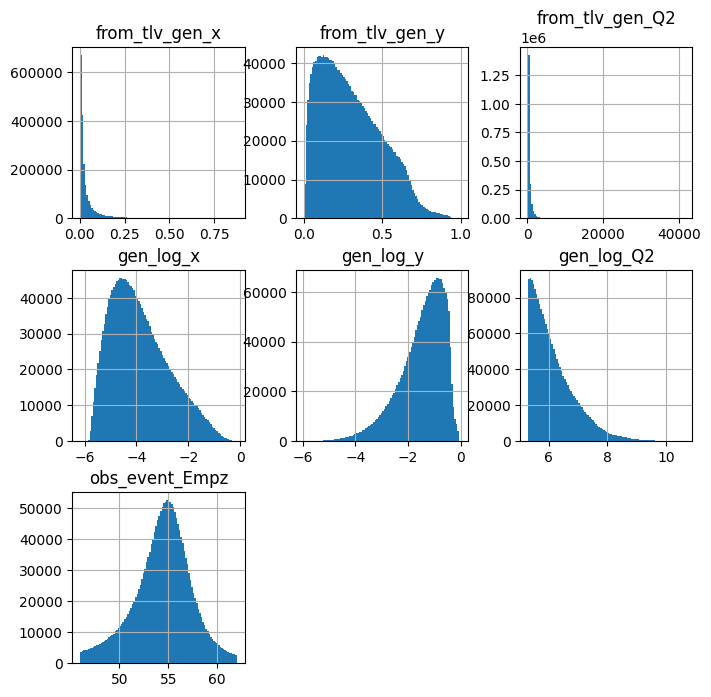

In [35]:
pandas_df.hist( figsize=(8,8), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz',
                        ])
plt.show()

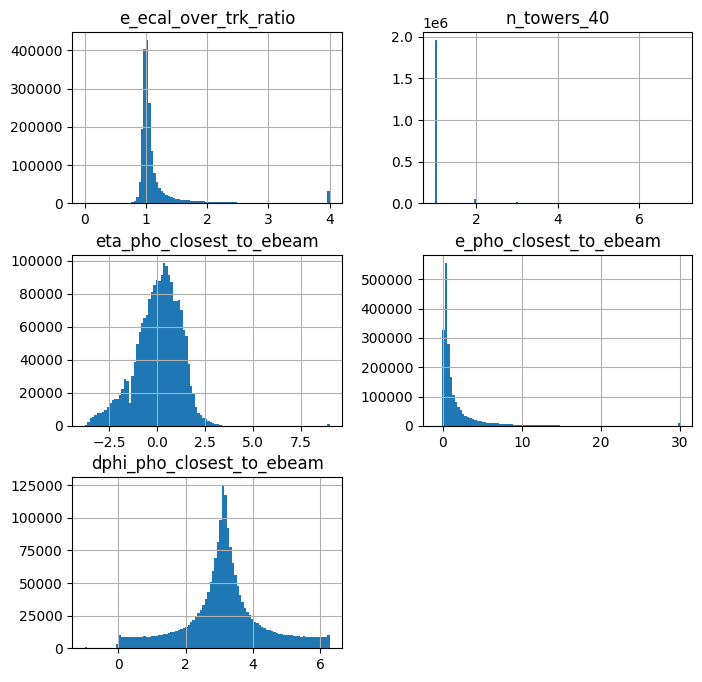

In [36]:

pandas_df.hist( figsize=(8,8), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


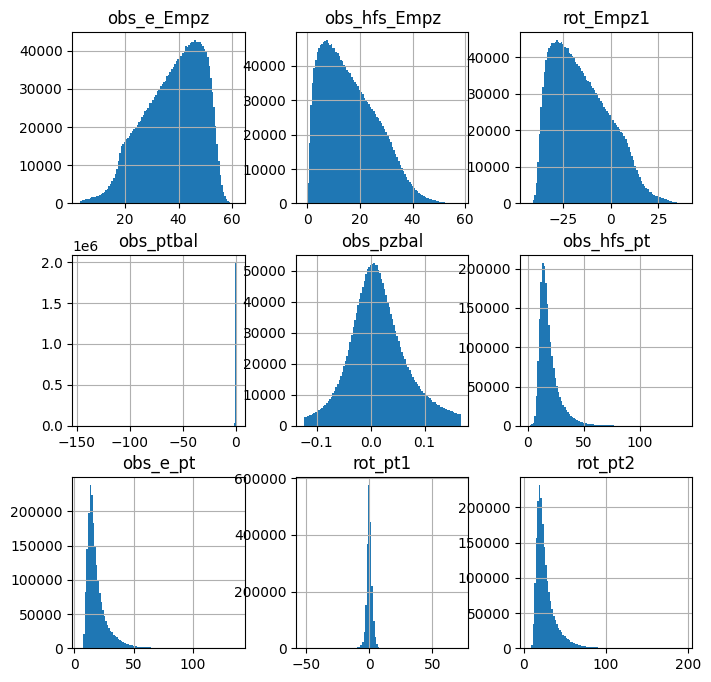

In [37]:
pandas_df.hist( figsize=(8,8), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

plt.show()

## Set up machine learning

In [38]:
# CELL 1: Imports and GPU setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [39]:
# Let's select the features that are used in the paper

sel_list =  ('e_ecal_over_trk_ratio','n_towers_40','eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam','dphi_pho_closest_to_ebeam','obs_e_pz','obs_e_e','obs_hfs_pz','obs_hfs_e', 'rot_pt1', 'rot_Empz1', 'rot_pt2', 'obs_pzbal', 'obs_ptbal', 'obs_dphi')
sel_list = list(sel_list)

target_list = ('gen_log_x','gen_log_Q2','gen_log_y')
target_list = list(target_list)

sel_X = pandas_df[sel_list]
target_y = pandas_df[target_list]

sub_df = sel_X[: 1000]
corr_matrix = sub_df.corr()


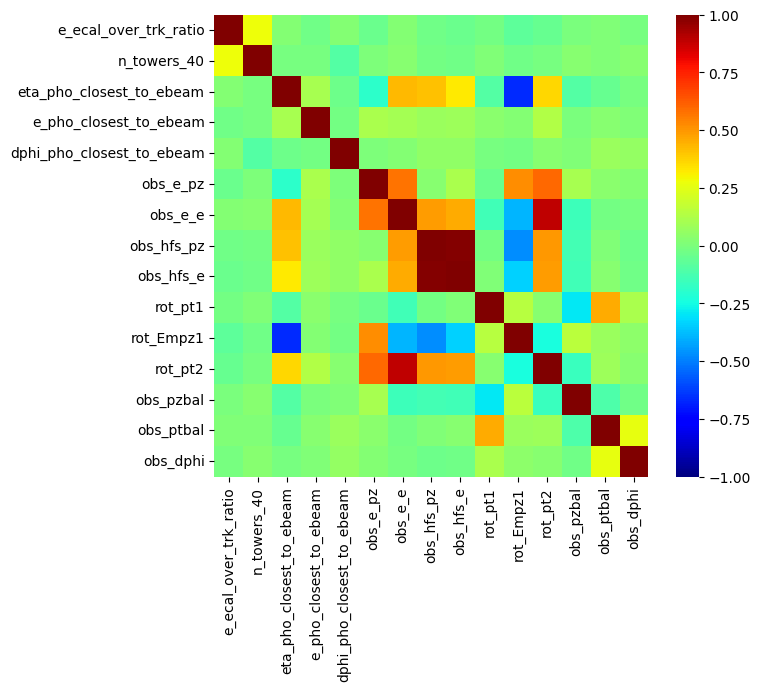

In [40]:
plt.figure(figsize=(7, 6))

sns.heatmap(corr_matrix, cmap='jet', vmin=-1, vmax=1,
            annot=False, fmt='.2f', xticklabels=sub_df.columns, yticklabels=sub_df.columns)
plt.show()

In [44]:
X = sel_X.values

Y_r = target_y.values

GY = pandas_df['from_tlv_gen_y'].to_numpy()

scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)

scalerY = StandardScaler()
scalerY.fit(Y_r)
Y_r = scalerY.transform(Y_r)

#-- Save the scaler transformations!  These are essential when reusing the training with a different dataset.

try:
    os.mkdir( '%s-scalers' % training_extname )
except:
    print('\n  Dir %s-scalers already exists\n\n' % training_extname )


print('\n\n Saving the input and learning target scalers:\n')
print('    %s-scalers/input_scaler.pkl' % training_extname )
print('    %s-scalers/target_scaler.pkl' % training_extname )

dump( scalerX, open('%s-scalers/input_scaler.pkl' % training_extname , 'wb'))
dump( scalerY, open('%s-scalers/target_scaler.pkl' % training_extname , 'wb'))

X_train, X_test, Y_r_train, Y_r_test, GY_train, GY_test = train_test_split( X,  Y_r, GY,  test_size=0.2) #80/20 split



  Dir /content/drive/My Drive/TMP/training_h1_reg_hugs25_v1-scalers already exists




 Saving the input and learning target scalers:

    /content/drive/My Drive/TMP/training_h1_reg_hugs25_v1-scalers/input_scaler.pkl
    /content/drive/My Drive/TMP/training_h1_reg_hugs25_v1-scalers/target_scaler.pkl


In [45]:
print(type(X),np.shape(X))

<class 'numpy.ndarray'> (2027827, 15)


In [46]:
print(np.shape(X_train),np.shape(Y_r_train))
print(np.shape(X_test),np.shape(Y_r_test))
print("GY_train shape: ",np.shape(GY_train))
print("GY_test shape: ",np.shape(GY_test))

(1622261, 15) (1622261, 3)
(405566, 15) (405566, 3)
GY_train shape:  (1622261,)
GY_test shape:  (405566,)


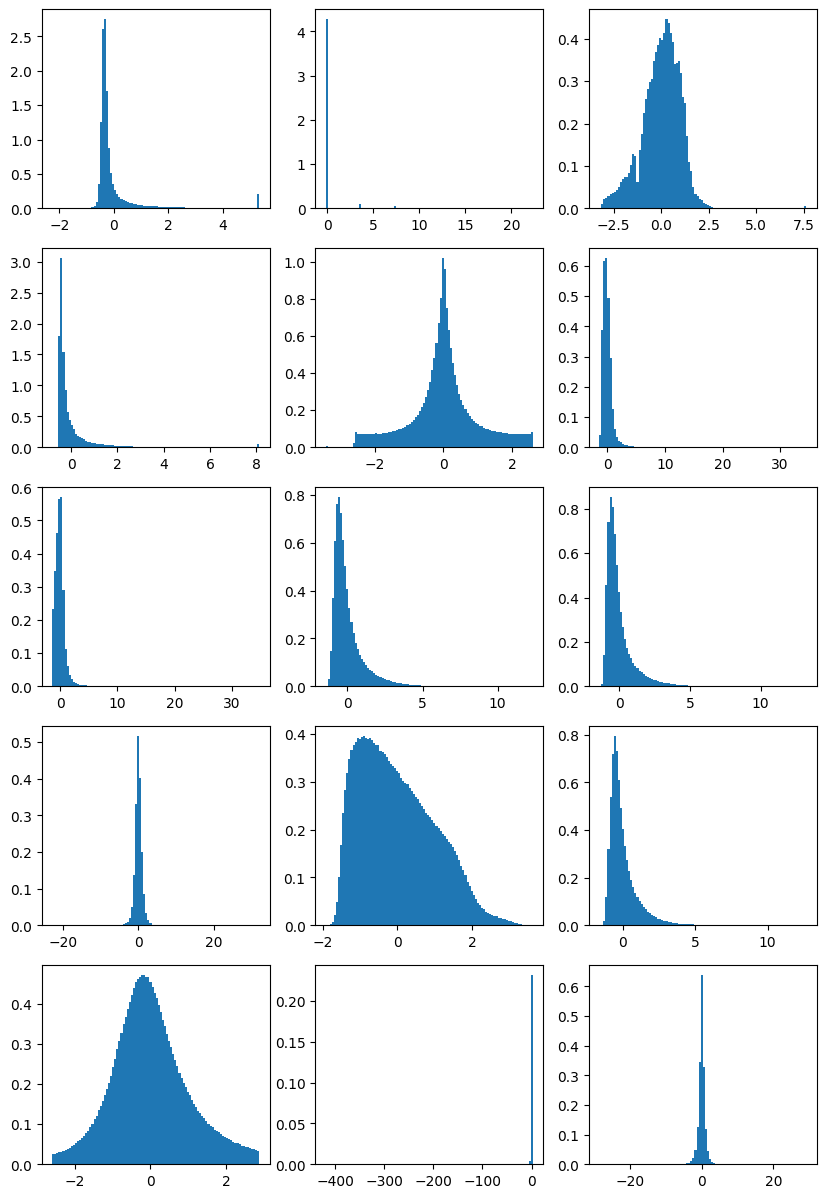

In [47]:
fig, ax = plt.subplots(5, 3, figsize=(10, 15))

for i in range(5):
    for j in range(3):
        idx = i * 3 + j
        if idx < X.shape[1]:  # check if we're still within the number of columns in X
            ax[i][j].hist(X[:, idx], density=True, bins=100)
        else:
            ax[i][j].axis('off')  # turn off remaining axes

plt.show()

## Set up the regression network

In [52]:

class RegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 64)
        #self.drop1 = nn.Dropout(dropout_setval)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.drop1(x)
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = F.selu(self.fc6(x))
        x = F.selu(self.fc7(x))
        return self.fc_out(x)

model = RegressionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate_setval_reg, amsgrad=amsgrad_setval)
loss_fn = nn.HuberLoss(delta=delta_setval)
# the Huber loss is used in robust regression,
# less sensitive to outliers in data than the squared error loss

In [56]:
%%time
# Training loop with early stopping

best_model_name = saving_dir + "best_model.pt"

early_stop_patience = 5 # this value is to quickly run the code and can be made larger

train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                           torch.tensor(Y_r_train, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                         torch.tensor(Y_r_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=batch_size_setval, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size_setval)

best_val_loss = float('inf')
patience_counter = 0

from tqdm import tqdm
import time

l_train_losses = []
l_val_losses = []

for epoch in range(max_epochs):
    print(f"\n================Epoch {epoch+1}/{max_epochs}")
    model.train()

    train_losses = []
    val_losses = []
    start_time = time.time()

    train_loader_iter = tqdm(train_loader, total=len(train_loader), desc="", leave=False)

    for xb, yb in train_loader_iter:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()       # computes gradients
        optimizer.step()      # updates model parameters with gradients
        optimizer.zero_grad() # resets all gradients to zero before the next backpropagation step
        train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss = loss_fn(pred, yb)
            val_losses.append(val_loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)

    l_train_losses.append(avg_train_loss)
    l_val_losses.append(avg_val_loss)

    duration = time.time() - start_time

    print(f"{len(train_loader)} batches [{duration:.0f}s] - loss: {avg_train_loss:1.6f} - val_loss: {avg_val_loss:1.6f}")



    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_name)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break



================Epoch 1/50


1585 batches [25s] - loss: 0.000565 - val_loss: 0.000571

================Epoch 2/50


1585 batches [28s] - loss: 0.000563 - val_loss: 0.000564

================Epoch 3/50


1585 batches [29s] - loss: 0.000559 - val_loss: 0.000559

================Epoch 4/50


1585 batches [25s] - loss: 0.000557 - val_loss: 0.000558

================Epoch 5/50


1585 batches [25s] - loss: 0.000555 - val_loss: 0.000554

================Epoch 6/50


1585 batches [25s] - loss: 0.000553 - val_loss: 0.000560

================Epoch 7/50


1585 batches [25s] - loss: 0.000550 - val_loss: 0.000565

================Epoch 8/50


1585 batches [25s] - loss: 0.000548 - val_loss: 0.000550

================Epoch 9/50


1585 batches [25s] - loss: 0.000546 - val_loss: 0.000548

================Epoch 10/50


1585 batches [25s] - loss: 0.000545 - val_loss: 0.000549

================Epoch 11/50


1585 batches [25s] - loss: 0.000542 - val_loss: 0.000547

================Epoch 12/50


1585 batches [25s] - loss: 0.000541 - val_loss: 0.000546

================Epoch 13/50


1585 batches [24s] - loss: 0.000539 - val_loss: 0.000550

================Epoch 14/50


1585 batches [24s] - loss: 0.000537 - val_loss: 0.000543

================Epoch 15/50


1585 batches [24s] - loss: 0.000536 - val_loss: 0.000538

================Epoch 16/50


1585 batches [25s] - loss: 0.000535 - val_loss: 0.000544

================Epoch 17/50


1585 batches [25s] - loss: 0.000533 - val_loss: 0.000554

================Epoch 18/50


1585 batches [25s] - loss: 0.000531 - val_loss: 0.000551

================Epoch 19/50


1585 batches [25s] - loss: 0.000530 - val_loss: 0.000540

================Epoch 20/50


1585 batches [25s] - loss: 0.000529 - val_loss: 0.000531

================Epoch 21/50


1585 batches [25s] - loss: 0.000528 - val_loss: 0.000528

================Epoch 22/50


1585 batches [24s] - loss: 0.000526 - val_loss: 0.000528

================Epoch 23/50


1585 batches [24s] - loss: 0.000525 - val_loss: 0.000526

================Epoch 24/50


1585 batches [25s] - loss: 0.000524 - val_loss: 0.000537

================Epoch 25/50


1585 batches [25s] - loss: 0.000523 - val_loss: 0.000533

================Epoch 26/50


1585 batches [25s] - loss: 0.000522 - val_loss: 0.000522

================Epoch 27/50


1585 batches [24s] - loss: 0.000521 - val_loss: 0.000524

================Epoch 28/50


1585 batches [25s] - loss: 0.000520 - val_loss: 0.000527

================Epoch 29/50


1585 batches [25s] - loss: 0.000519 - val_loss: 0.000523

================Epoch 30/50


1585 batches [24s] - loss: 0.000518 - val_loss: 0.000529

================Epoch 31/50


1585 batches [24s] - loss: 0.000517 - val_loss: 0.000517

================Epoch 32/50


1585 batches [24s] - loss: 0.000516 - val_loss: 0.000521

================Epoch 33/50


1585 batches [25s] - loss: 0.000515 - val_loss: 0.000518

================Epoch 34/50


1585 batches [25s] - loss: 0.000515 - val_loss: 0.000515

================Epoch 35/50


1585 batches [25s] - loss: 0.000513 - val_loss: 0.000516

================Epoch 36/50


1585 batches [25s] - loss: 0.000513 - val_loss: 0.000525

================Epoch 37/50


1585 batches [25s] - loss: 0.000512 - val_loss: 0.000521

================Epoch 38/50


1585 batches [25s] - loss: 0.000511 - val_loss: 0.000511

================Epoch 39/50


1585 batches [25s] - loss: 0.000511 - val_loss: 0.000513

================Epoch 40/50


1585 batches [24s] - loss: 0.000510 - val_loss: 0.000513

================Epoch 41/50


1585 batches [25s] - loss: 0.000509 - val_loss: 0.000517

================Epoch 42/50


1585 batches [25s] - loss: 0.000508 - val_loss: 0.000516

================Epoch 43/50


1585 batches [25s] - loss: 0.000508 - val_loss: 0.000512
Early stopping triggered.
CPU times: user 17min 28s, sys: 7.19 s, total: 17min 35s
Wall time: 17min 50s


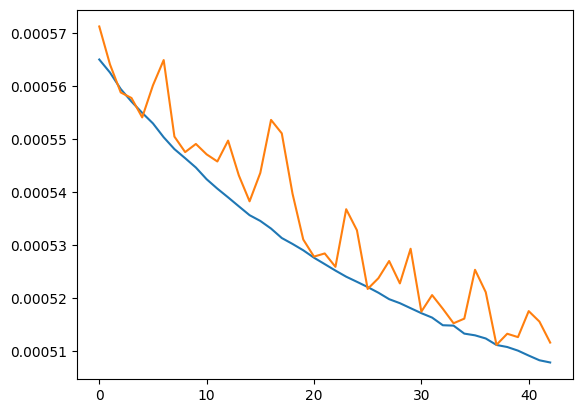

In [57]:
plt.plot(l_train_losses)
plt.plot(l_val_losses)

In [58]:
# Save the model weights
filepath_model = training_extname + "_regression.pt"
torch.save(model.state_dict(), filepath_model)

# Run predictions on test set (already a NumPy array)
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    mypreds_r = model(X_test_tensor).cpu().numpy()


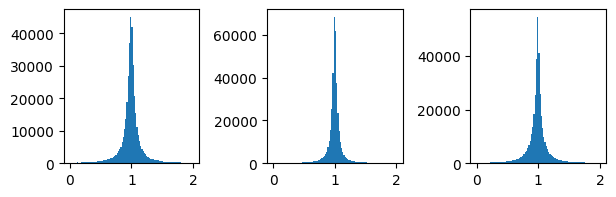

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(7, 2))

# Avoid divide-by-zero if any target is near 0
eps = 1e-8

ax[0].hist(mypreds_r[:, 0] / (Y_r_test[:, 0] + eps), bins=100, range=[0, 2])
ax[1].hist(mypreds_r[:, 1] / (Y_r_test[:, 1] + eps), bins=100, range=[0, 2])
ax[2].hist(mypreds_r[:, 2] / (Y_r_test[:, 2] + eps), bins=100, range=[0, 2])

plt.subplots_adjust(wspace=0.5)
plt.show()


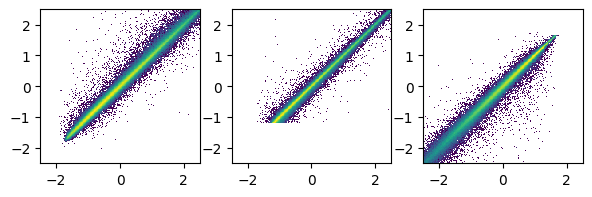

In [60]:
fig,ax = plt.subplots(1,3,figsize=(7,2))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

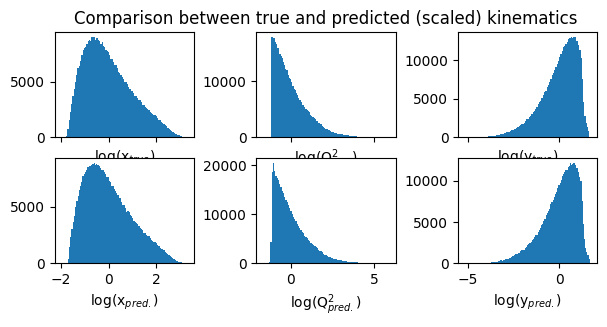

In [61]:
fig,ax = plt.subplots(2,3,figsize=(7,3), sharex='col')

# define titles and x-labels
true_labels = ['log(x$_{true})$', 'log(Q$^2_{true})$', 'log(y$_{true})$']
pred_labels = ['log(x$_{pred.})$', 'log(Q$^2_{pred.})$', 'log(y$_{pred.})$']

ax[0][1].set_title("Comparison between true and predicted (scaled) kinematics") # title for the first row

for i in range(3):
    ax[0][i].hist(Y_r_test[:,i], bins=100)
    ax[0][i].set_xlabel(true_labels[i]) # x-label for the upper plots

    ax[1][i].hist(mypreds_r[:,i], bins=100)
    ax[1][i].set_xlabel(pred_labels[i]) # x-label for the lower plots

plt.subplots_adjust(wspace=0.45)
plt.show()

In [62]:
# Inverse transform to their unscaled values (i.e., before standard scaling)

inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y)
pred_vals = np.exp( inv_trans_pred)

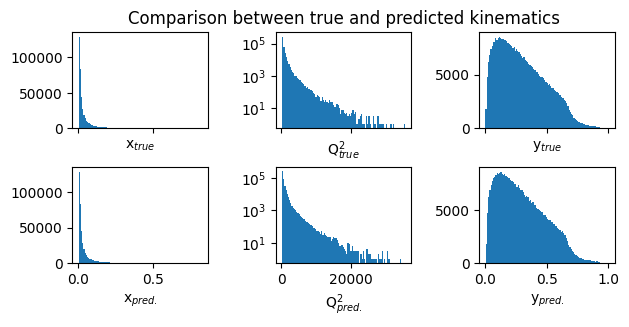

In [63]:
fig,ax = plt.subplots(2,3,figsize=(7,3), sharex='col')

# define titles and x-labels
true_labels = ['x$_{true}$', 'Q$^2_{true}$', 'y$_{true}$']
pred_labels = ['x$_{pred.}$', 'Q$^2_{pred.}$', 'y$_{pred.}$']

ax[0][1].set_title("Comparison between true and predicted kinematics") # title for the first row

for i in range(3):
    ax[0][i].hist(true_vals[:,i], bins=100)
    ax[0][i].set_xlabel(true_labels[i]) # x-label for the upper plots

    ax[1][i].hist(pred_vals[:,i], bins=100)
    ax[1][i].set_xlabel(pred_labels[i]) # x-label for the lower plots

ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.5)
plt.show()

## Plots of Ratio(pred/true) for target variables : transformed log(x), log(y), and log(Q2)

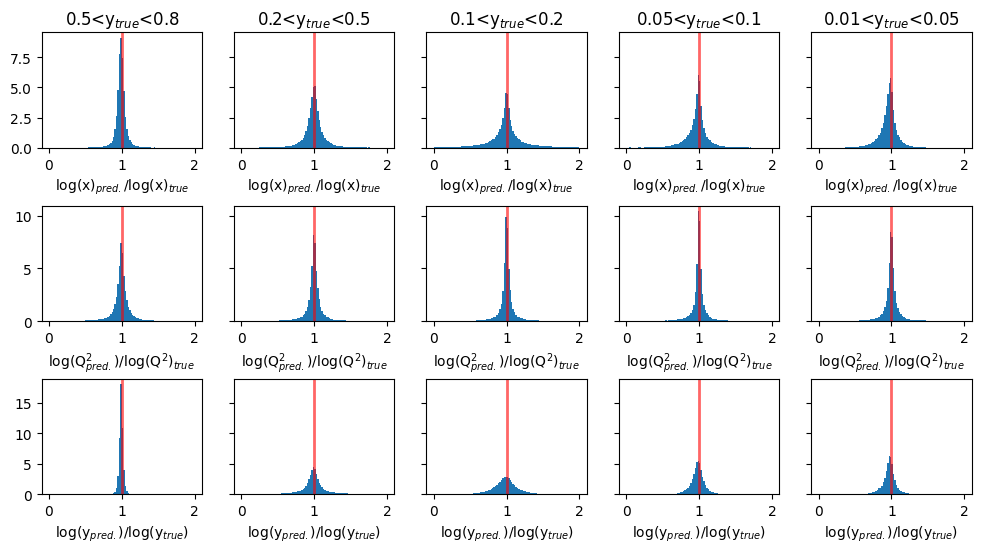

In [64]:
fig, ax = plt.subplots(3,5, figsize=(12,6), sharey='row')

titles = ['log(x)$_{pred.}$/log(x)$_{true}$', 'log(Q$^2_{pred.}$)/log(Q$^2$)$_{true}$', 'log(y$_{pred.}$)/log(y$_{true}$)']
y_ranges = [
    (0.5, 0.8),
    (0.2, 0.5),
    (0.1, 0.2),
    (0.05, 0.1),
    (0.01, 0.05)
]

for i in range(3):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        ax[i][j].hist(mypreds_r[:,i][mask]/Y_r_test[mask][:,i],
                      density=True,bins=100,range=(0,2))
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)
        ax[i][j].set_xlabel(titles[i])  # set column x-label

        if i == 0:
            ax[i][j].set_title(f'{y_min}<y$_{{true}}$<{y_max}')

plt.subplots_adjust(hspace=0.5)
plt.show()


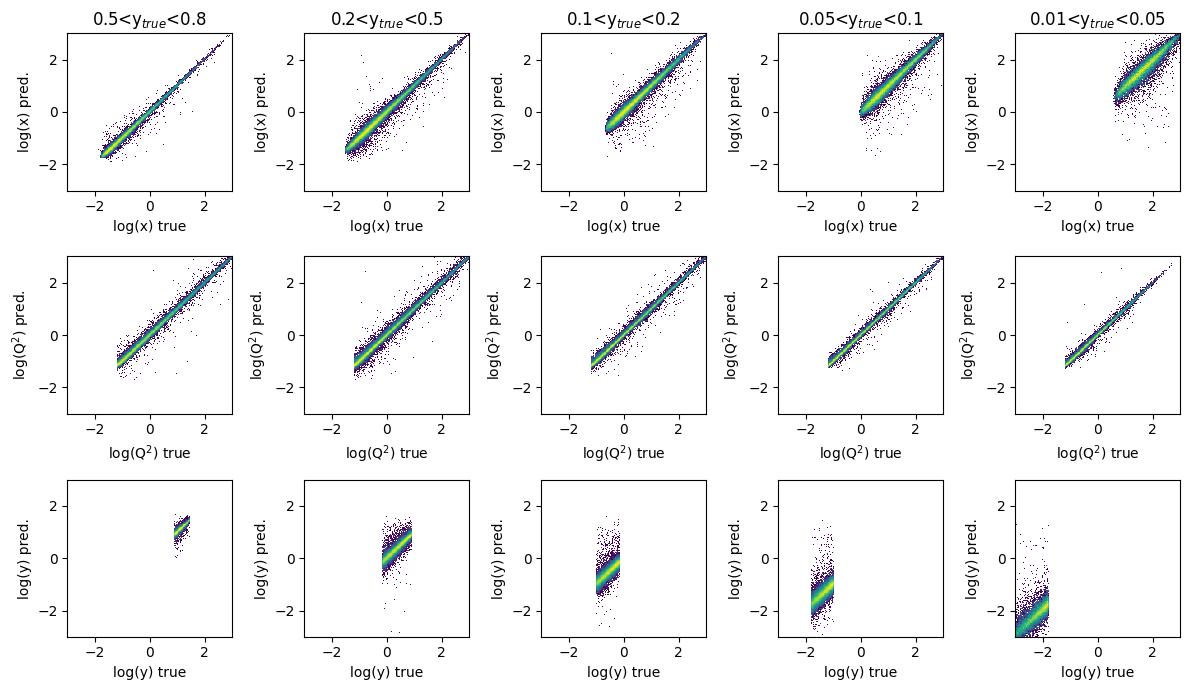

In [65]:
fig, ax = plt.subplots(3, 5, figsize=(12, 7))

titles = ['log(x)', 'log(Q$^2$)', 'log(y)']
y_ranges = [
    (0.5, 0.8),
    (0.2, 0.5),
    (0.1, 0.2),
    (0.05, 0.1),
    (0.01, 0.05)
]

for i in range(3):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        ax[i][j].hist2d(Y_r_test[mask][:,i],
                        mypreds_r[:,i][mask],
                        density=True,bins=200,range=([-3,3],[-3,3]),
                        norm=mpl.colors.LogNorm())

        if i == 0:
            ax[i][j].set_title(f'{y_min}<y$_{{true}}$<{y_max}')

        ax[i][j].set_ylabel(titles[i] + ' pred.')
        ax[i][j].set_xlabel(titles[i] + ' true')

plt.tight_layout()
plt.show()


## Plots of predicted and true physics variable : x

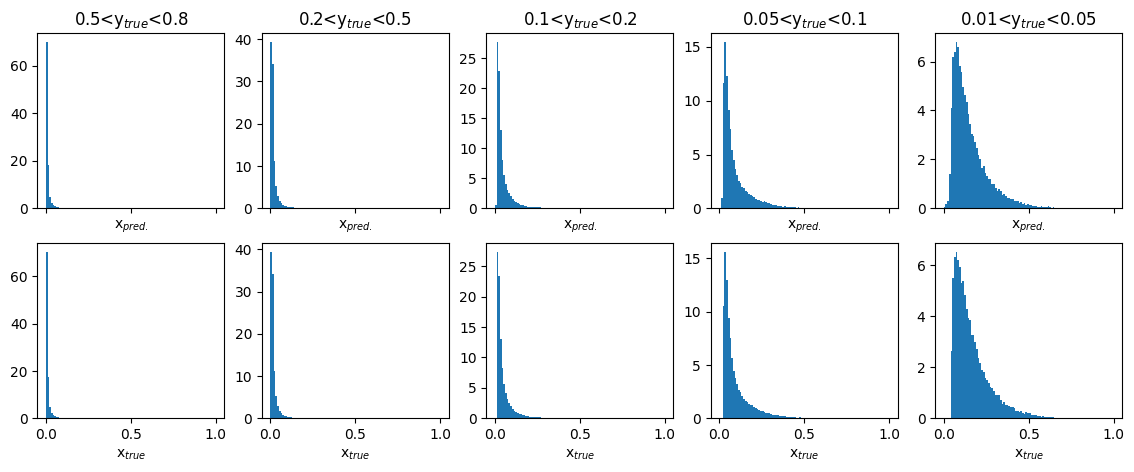

In [66]:
fig,ax = plt.subplots(2,5,figsize=(14,5),sharex='col')

y_ranges = [(0.5, 0.8),(0.2, 0.5),(0.1, 0.2),(0.05, 0.1),(0.01, 0.05)]

for i in range(2):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        if i == 0:
            ax[i][j].hist(pred_vals[:,0][mask],density=True,bins=100,range=(0,1))
            ax[i][j].set_title(f'{y_min}<y$_{{true}}$<{y_max}')
            ax[i][j].set_xlabel('x$_{pred.}$')
        else:
            ax[i][j].hist(true_vals[:,0][mask],density=True,bins=100,range=(0,1))
            ax[i][j].set_xlabel('x$_{true}$')

plt.show()


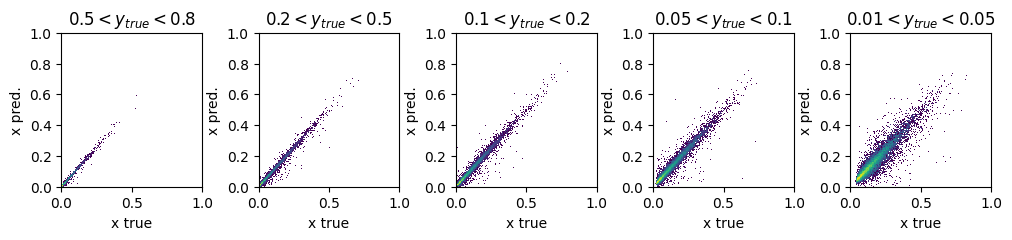

In [67]:
fig, ax = plt.subplots(1,5, figsize=(12,2))

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5<y_{true}<0.8$', '$0.2<y_{true}<0.5$', '$0.1<y_{true}<0.2$', '$0.05<y_{true}<0.1$', '$0.01<y_{true}<0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist2d(true_vals[:,0][mask], pred_vals[:,0][mask],
                 density=True, bins=200, range=([0,1],[0,1]), norm=mpl.colors.LogNorm())
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('x true')
    ax[i].set_ylabel('x pred.')


plt.subplots_adjust(wspace=0.4)

plt.show()


## Plots of predicted and true physics variable : Q2

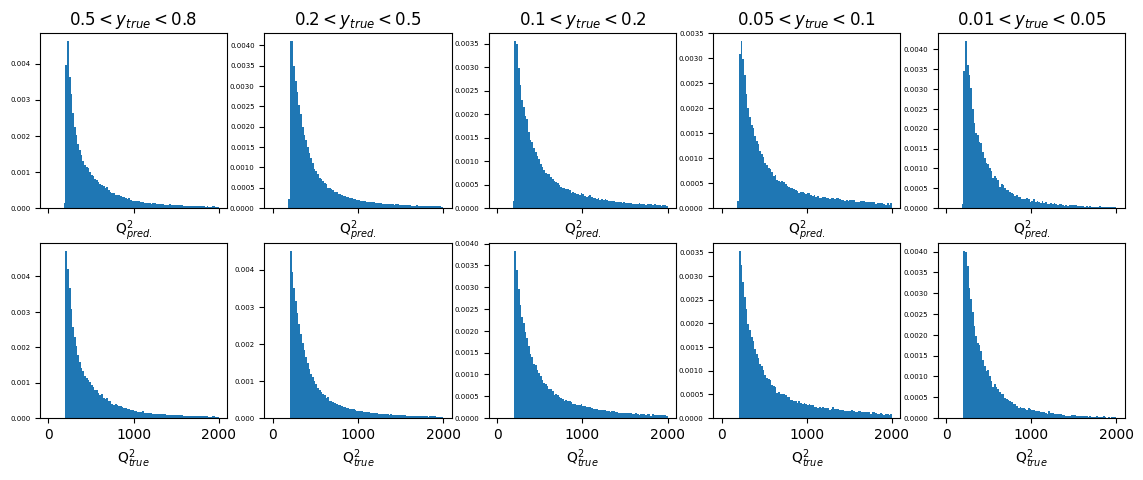

In [68]:
fig, ax = plt.subplots(2, 5, figsize=(14, 5), sharex='col')

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
xmax = 2000
titles = ['$0.5<y_{true}<0.8$', '$0.2<y_{true}<0.5$', '$0.1<y_{true}<0.2$', '$0.05<y_{true}<0.1$', '$0.01<y_{true}<0.05$']
x_labels = ['Q$^{2}_{pred.}$', 'Q$^{2}_{true}$']

for i in range(2):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        ax[i][j].hist(pred_vals[:,1][mask] if i == 0 else true_vals[:,1][mask],
                      density=True, bins=100, range=(0, xmax))
        if i==0:
          ax[i][j].set_title(titles[j])
        ax[i][j].set_xlabel(x_labels[i])
        ax[i][j].tick_params(axis='y', labelsize=5)  # adjust the fontsize of y-axis

plt.show()


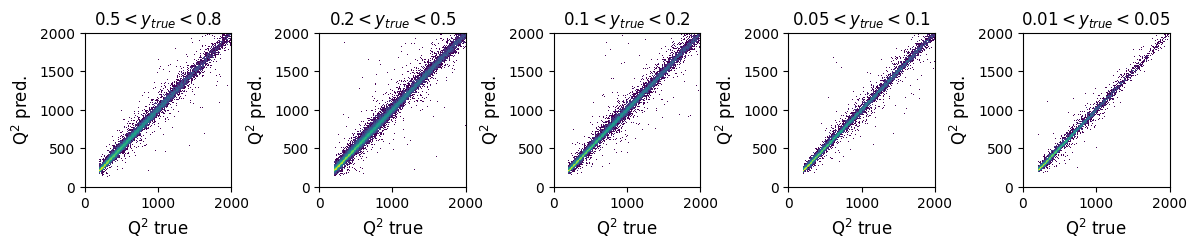

In [69]:
fig, ax = plt.subplots(1, 5, figsize=(14, 2))
axis_max = 2000

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']
x_label = 'Q$^{2}$ true'
y_label = 'Q$^{2}$ pred.'

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist2d(true_vals[:, 1][mask], pred_vals[:, 1][mask],
                 density=True, bins=200, range=([0, axis_max], [0, axis_max]), norm=mpl.colors.LogNorm())
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Q$^{2}$ pred.')
    ax[i].set_xlabel(x_label)
    ax[i].set_xlabel(x_label, fontsize=12)
    ax[i].set_ylabel(y_label, fontsize=12)

plt.subplots_adjust(wspace=0.6)
plt.show()


## Plots of predicted and true physics variable : y

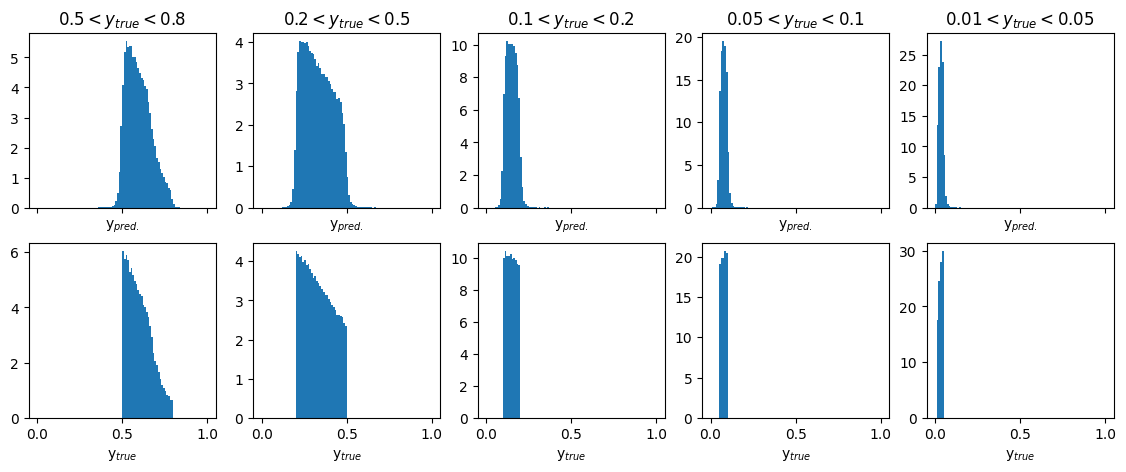

In [70]:
fig, ax = plt.subplots(2, 5, figsize=(14, 5), sharex='col')
xmax = 1

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']
x_label = ['y$_{pred.}$','y$_{true}$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[0][i].hist(pred_vals[:, 2][mask], density=True, bins=100, range=(0, xmax))
    ax[1][i].hist(true_vals[:, 2][mask], density=True, bins=100, range=(0, xmax))
    ax[0][i].set_title(titles[i])
    ax[0][i].set_xlabel(x_label[0])
    ax[1][i].set_xlabel(x_label[1])

plt.show()


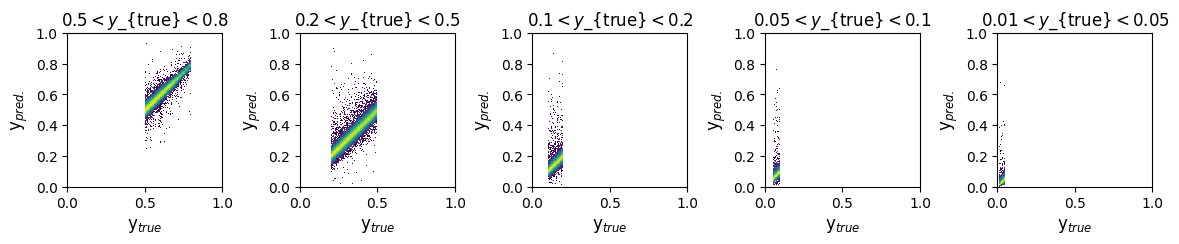

In [71]:
fig, ax = plt.subplots(1, 5, figsize=(14, 2))
axis_max = 1

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y$_{true}$ < 0.8$', '$0.2 < y$_{true}$ < 0.5$', '$0.1 < y$_{true}$ < 0.2$', '$0.05 < y$_{true}$ < 0.1$', '$0.01 < y$_{true}$ < 0.05$']
x_label = 'y$_{true}$'
y_label = 'y$_{pred.}$'

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist2d(true_vals[:, 2][mask], pred_vals[:, 2][mask], density=True, bins=200, range=([0, axis_max], [0, axis_max]), norm=mpl.colors.LogNorm())
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(x_label)
    ax[i].set_ylabel(y_label)
    ax[i].set_xlabel(x_label, fontsize=12)
    ax[i].set_ylabel(y_label, fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.show()


## Plots of pred/true of physics variable x

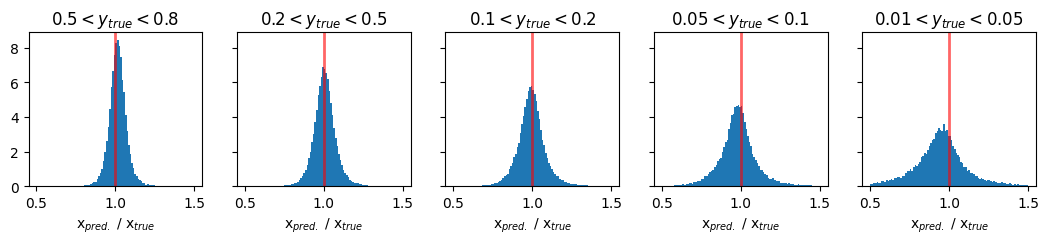

In [72]:
fig, ax = plt.subplots(1, 5, figsize=(13, 2), sharey='row')
xmin = 0.5
xmax = 1.5
y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist(pred_vals[:, 0][mask] / true_vals[:, 0][mask], density=True, bins=100, range=(xmin, xmax))
    ax[i].set_title(titles[i])
    ax[i].axvline(1.0, color='red', lw=2, alpha=0.6)
    ax[i].set_xlabel('x$_{pred.}$ / x$_{true}$')

plt.show()


## Plots of pred/true of physics variable Q2

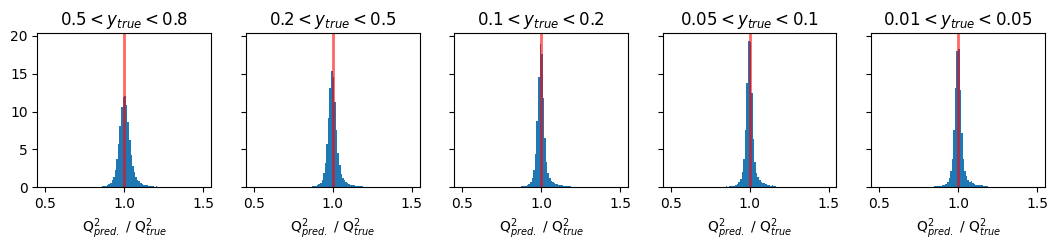

In [73]:
fig, ax = plt.subplots(1, 5, figsize=(13, 2), sharey='row')
xmin = 0.5
xmax = 1.5
y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist(pred_vals[:, 1][mask] / true_vals[:, 1][mask], density=True, bins=100, range=(xmin, xmax))
    ax[i].set_title(titles[i])
    ax[i].axvline(1.0, color='red', lw=2, alpha=0.6)
    ax[i].set_xlabel('Q$^{2}_{pred.}$ / Q$^{2}_{true}$')

plt.show()


## Plots of pred/true of physics variable y

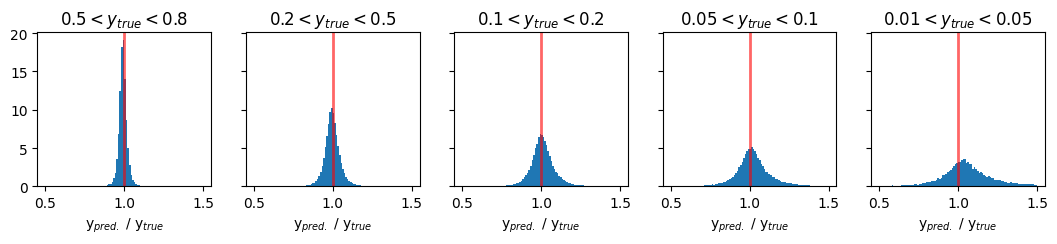

In [74]:
fig, ax = plt.subplots(1, 5, figsize=(13, 2), sharey='row')
xmin = 0.5
xmax = 1.5
y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist(pred_vals[:, 2][mask] / true_vals[:, 2][mask], density=True, bins=100, range=(xmin, xmax))
    ax[i].set_title(titles[i])
    ax[i].axvline(1.0, color='red', lw=2, alpha=0.6)
    ax[i].set_xlabel('y$_{pred.}$ / y$_{true}$')

plt.show()


## Comparison plots of resolution for methods vs DNN


## Resolution in x

In [81]:
print(pandas_df['obs_x'].tail(5))

9999977    [0.004924382083117962 -0.0046023097820580006 0...
9999984    [0.08789674937725067 0.0698225274682045 0.0582...
9999990    [0.008899795822799206 0.007692348212003708 0.0...
9999991    [0.006072165910154581 -0.004472089000046253 0....
9999996    [0.058499809354543686 0.05831887200474739 0.05...
Name: obs_x, dtype: awkward


In [83]:
pandas_df['obs_x'].iloc[-1]

<Array [0.0585, 0.0583, 0.0579, ..., 0.0583, 0.0583, 0.0583] type='9 * float32'>

In [85]:
print(pandas_df['obs_x'].iloc[0])
print(type(pandas_df['obs_x'].iloc[0]))

[0.0153, 0.0196, 0.00937, 0.0115, 0.0142, 0.0119, 0.0125, 0.0125, 0.0119]
<class 'awkward.highlevel.Array'>


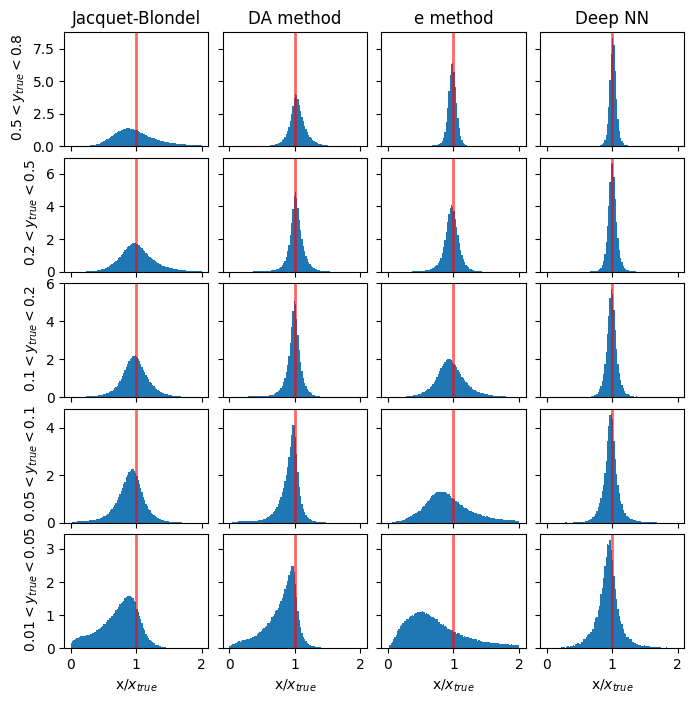

In [88]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

mean_xratio = []
rms_xratio = []

def cal_mean_rms(bin_edges,counts, mean_l, rms_l):
  bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
  mean = np.average(bin_centers, weights=counts)
  rms = np.sqrt(np.average((bin_centers - mean) ** 2, weights=counts))
  mean_l.append(mean)
  rms_l.append(rms)
  return mean_l, rms_l

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
xmin = 0.0
xmax = 2.0
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(8, 8), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        #counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_x[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_x'],
        #               density=True, bins=100, range=(xmin, xmax))

        counts, bin_edges, _ = ax[yi][i].hist(
            pandas_df.query(y_cut[yi])['obs_x'].apply(lambda x: x[mi]) /
            pandas_df.query(y_cut[yi])['from_tlv_gen_x'],
            density=True, bins=100, range=(xmin, xmax)
        )

        if(yi==0):
          ax[yi][i].set_title(methods_labels[i])

        mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)



# the DNN method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)].hist(pred_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('Deep NN')

    mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)


for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$')

if(len(y_cut)>0):
  for i in range(len(methods_to_use)+1):
      ax[len(y_cut)-1][i].set_xlabel('x/$x_{true}$')

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+1): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Resolution in Q2

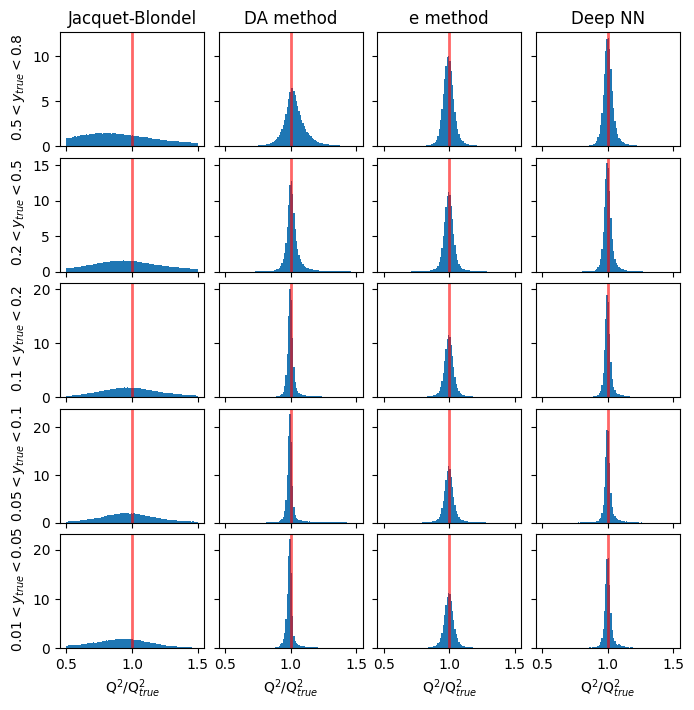

In [89]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined


mean_Q2ratio = []
rms_Q2ratio = []

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
xmin = 0.5
xmax = 1.5
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(8, 8), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        #counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'],
        #               density=True, bins=100, range=(xmin, xmax))

        counts, bin_edges, _ = ax[yi][i].hist(
            pandas_df.query(y_cut[yi])['obs_Q2'].apply(lambda x: x[mi]) /
            pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'],
            density=True, bins=100, range=(xmin, xmax)
        )

        if(yi==0):
          ax[yi][i].set_title(methods_labels[i])

        mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)


# the DNN method
for yi in range(len(y_cut)):
    counts, bin_edges, _ =  ax[yi][len(methods_to_use)].hist(pred_vals[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 1][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('Deep NN')

    mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)


for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$')

if(len(y_cut)>0):
  for i in range(len(methods_to_use)+1):
      ax[len(y_cut)-1][i].set_xlabel('Q$^2$/Q$^2_{true}$')

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+1): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Resolution in y

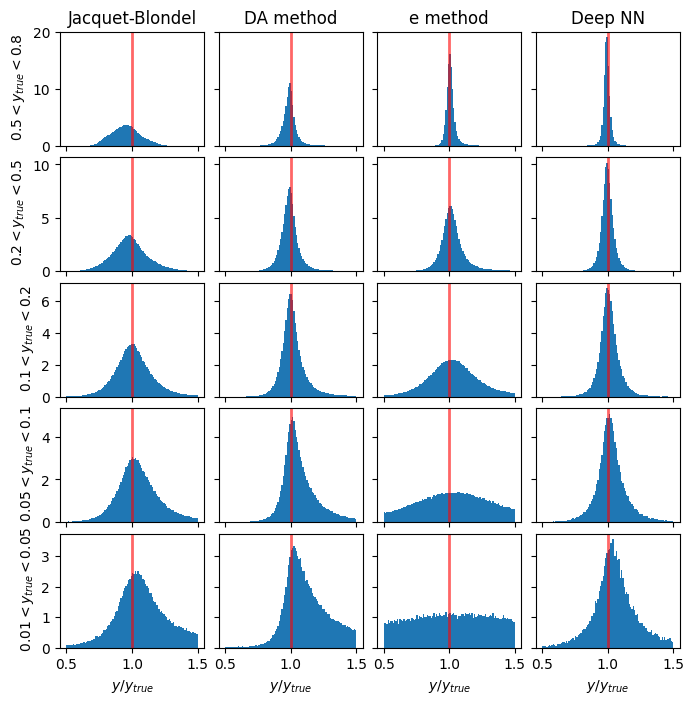

In [90]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

mean_yratio = []
rms_yratio = []

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
xmin = 0.5
xmax = 1.5
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(8, 8), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        #counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_y[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_y'],
        #               density=True, bins=100, range=(xmin, xmax))

        counts, bin_edges, _ = ax[yi][i].hist(
            pandas_df.query(y_cut[yi])['obs_y'].apply(lambda x: x[mi]) /
            pandas_df.query(y_cut[yi])['from_tlv_gen_y'],
            density=True, bins=100, range=(xmin, xmax)
        )

        if(yi==0):
          ax[yi][i].set_title(methods_labels[i])

        mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)



# the DNN method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)].hist(pred_vals[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 2][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('Deep NN')

    mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)



for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$')

if(len(y_cut)>0):
  for i in range(len(methods_to_use)+1):
      ax[len(y_cut)-1][i].set_xlabel('$y/y_{true}$')

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+1): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


### Plotting the results as a function of y

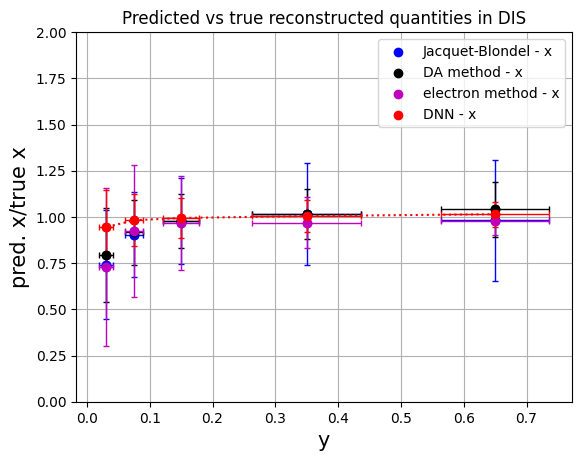

In [91]:

# convert to numpy arrays for manipulation
# methods: 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

ykin = []
err_ykin = []

for values in y_ranges:
  tmp = 0.5*(values[0]+values[1])
  ykin.append(tmp)
  tmp = abs(values[1]-values[0])
  err_ykin.append(tmp/np.sqrt(12.))

ykin = np.array(ykin)
err_ykin = np.array(err_ykin)


meanx_jb = np.array(mean_xratio[0:5])
errx_jb = np.array(rms_xratio[0:5])

meanx_da = np.array(mean_xratio[5:10])
errx_da = np.array(rms_xratio[5:10])

meanx_e = np.array(mean_xratio[10:15])
errx_e = np.array(rms_xratio[10:15])

meanx_dnn = np.array(mean_xratio[15:20])
errx_dnn = np.array(rms_xratio[15:20])

plt.scatter(ykin, meanx_jb, color='b', label='Jacquet-Blondel - x')
plt.errorbar(ykin, meanx_jb, xerr=err_ykin, yerr=errx_jb, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2) #label='uncertainty'

plt.scatter(ykin, meanx_da, color='k', label='DA method - x')
plt.errorbar(ykin, meanx_da, xerr=err_ykin, yerr=errx_da, fmt='o', color='k', ecolor='k', elinewidth=1, capsize=2)

plt.scatter(ykin, meanx_e, color='m', label='electron method - x')
plt.errorbar(ykin, meanx_e, xerr=err_ykin, yerr=errx_e, fmt='o', color='m', ecolor='m', elinewidth=1, capsize=2)

plt.scatter(ykin, meanx_dnn, color='r', label='DNN - x')
plt.errorbar(ykin, meanx_dnn, xerr=err_ykin, yerr=errx_dnn, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, linestyle=':')


plt.xlabel('y',fontsize=15)
plt.ylabel('pred. x/true x',fontsize=15)
plt.ylim(0.,2.)
plt.title('Predicted vs true reconstructed quantities in DIS')
plt.legend()
plt.grid(True)
plt.show()

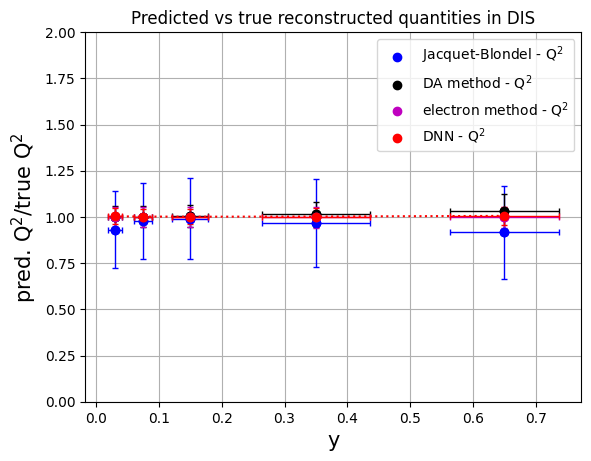

In [92]:

# convert to numpy arrays for manipulation
# methods: 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

meanQ2_jb = np.array(mean_Q2ratio[0:5])
errQ2_jb = np.array(rms_Q2ratio[0:5])

meanQ2_da = np.array(mean_Q2ratio[5:10])
errQ2_da = np.array(rms_Q2ratio[5:10])

meanQ2_e = np.array(mean_Q2ratio[10:15])
errQ2_e = np.array(rms_Q2ratio[10:15])

meanQ2_dnn = np.array(mean_Q2ratio[15:20])
errQ2_dnn = np.array(rms_Q2ratio[15:20])

plt.scatter(ykin, meanQ2_jb, color='b', label='Jacquet-Blondel - Q$^{2}$')
plt.errorbar(ykin, meanQ2_jb, xerr=err_ykin, yerr=errQ2_jb, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2) #label='uncertainty'

plt.scatter(ykin, meanQ2_da, color='k', label='DA method - Q$^{2}$')
plt.errorbar(ykin, meanQ2_da, xerr=err_ykin, yerr=errQ2_da, fmt='o', color='k', ecolor='k', elinewidth=1, capsize=2)

plt.scatter(ykin, meanQ2_e, color='m', label='electron method - Q$^{2}$')
plt.errorbar(ykin, meanQ2_e, xerr=err_ykin, yerr=errQ2_e, fmt='o', color='m', ecolor='m', elinewidth=1, capsize=2)

plt.scatter(ykin, meanQ2_dnn, color='r', label='DNN - Q$^{2}$')
plt.errorbar(ykin, meanQ2_dnn, xerr=err_ykin, yerr=errQ2_dnn, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, linestyle=':')


plt.xlabel('y',fontsize=15)
plt.ylabel('pred. Q$^{2}$/true Q$^{2}$',fontsize=15)
plt.ylim(0.,2.)
plt.title('Predicted vs true reconstructed quantities in DIS')
plt.legend()
plt.grid(True)
plt.show()

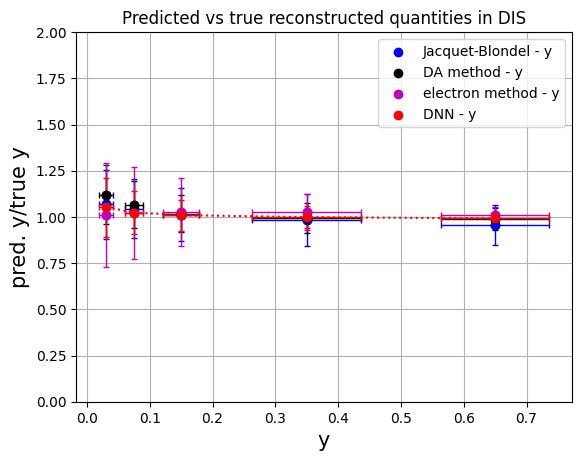

In [93]:

# convert to numpy arrays for manipulation
# methods: 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined


meany_jb = np.array(mean_yratio[0:5])
erry_jb = np.array(rms_yratio[0:5])

meany_da = np.array(mean_yratio[5:10])
erry_da = np.array(rms_yratio[5:10])

meany_e = np.array(mean_yratio[10:15])
erry_e = np.array(rms_yratio[10:15])

meany_dnn = np.array(mean_yratio[15:20])
erry_dnn = np.array(rms_yratio[15:20])

plt.scatter(ykin, meany_jb, color='b', label='Jacquet-Blondel - y')
plt.errorbar(ykin, meany_jb, xerr=err_ykin, yerr=erry_jb, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2) #label='uncertainty'

plt.scatter(ykin, meany_da, color='k', label='DA method - y')
plt.errorbar(ykin, meany_da, xerr=err_ykin, yerr=erry_da, fmt='o', color='k', ecolor='k', elinewidth=1, capsize=2)

plt.scatter(ykin, meany_e, color='m', label='electron method - y')
plt.errorbar(ykin, meany_e, xerr=err_ykin, yerr=erry_e, fmt='o', color='m', ecolor='m', elinewidth=1, capsize=2)

plt.scatter(ykin, meany_dnn, color='r', label='DNN - y')
plt.errorbar(ykin, meany_dnn, xerr=err_ykin, yerr=erry_dnn, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, linestyle=':')


plt.xlabel('y',fontsize=15)
plt.ylabel('pred. y/true y',fontsize=15)
plt.ylim(0.,2.)
plt.title('Predicted vs true reconstructed quantities in DIS')
plt.legend()
plt.grid(True)
plt.show()